In [1]:
import sys
import os
import os.path as op

import glob
import numpy as np
import pandas as pd
import datetime
import netCDF4 as netcdf
from math import pi
import xarray as xr
import datetime

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D as Line
from matplotlib.patches import Patch

# cartopy maps
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

# kml read
from pykml import parser
from geopy.distance import geodesic

# dev library
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..'))

# dependencies
from lib import spectra, plot_spectra, wrapSpectra, plot_sat, io
from lib.config import *

# 180º directional ambiguity removal - a case example
> Based on MFWAN model-partitions interpolated values to sat-boxes

In [2]:
# load data tracks and ww3 model output
ds_data = xr.open_dataset(op.join(p_output, 'ds_dataTracks.nc'))

In [3]:
ds_data

<xarray.Dataset>
Dimensions:    (file: 151, nbox: 505, posneg: 2)
Coordinates:
  * file       (file) object 'CFO_OP05_SWI_L2_____F_20210213T004756_20210213T...
  * nbox       (nbox) int64 7 8 9 10 11 12 13 14 ... 505 506 507 509 512 513 514
  * posneg     (posneg) int64 0 1
Data variables:
    longitude  (file, nbox, posneg) float32 ...
    latitude   (file, nbox, posneg) float32 ...
    time       (file, nbox, posneg) datetime64[ns] ...

## Selection L2 product observation

### Config SWIM parameters

> nadir side: (0 : right sides ; 1 :left side) <br>
> beam: 6=> beam 6°; 8=> beam 8°; 10=> beam 10° ; 0 => combined (combination of the 3 beams)<br>
> min wavelength (m), instrument specification : 70 m<br>
> max wavelength (m), instrument specification : 500 m<br>

In [4]:
# side of the nadir track to analyse 
nadir_side = 1

# beam choice for spectra 
beam = 10

# partitions visualization : True => partitions plotted; False => partitions not plotted
partitions = True

# color bar min and max values ('None' recommended)
vmin, vmax = None, None

# wave wavelength visualization range:
min_wavelength = 70
max_wavelength = 500 

**From the config params, the L2 file is selected**

In [13]:
dsi.nbox

<xarray.DataArray 'nbox' (nbox: 151)>
array([202, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222,
       223, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319,
       320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333,
       334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347,
       348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361,
       362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375,
       376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389,
       390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403,
       404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417,
       418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
       432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442])
Coordinates:
    file     <U56 'CFO_OP05_SWI_L2_____F_20210213T004756_20210213T022132.nc'
  * nbox     (nbox) int64 202 210 211 212 213 214 ... 437 438 439 440 441 442

In [14]:
# SWIM L2 NetCDF file full name (first file, first box)
dsi = ds_data.isel(file=0).dropna(dim='nbox')
SWIM_L2_NC_file_name = str(dsi.file.values)
num_box = dsi.nbox.values[0]
#num_box = 150
# 50, 33: same tp opposite direcctions

# NetCDF file opening and reading
cdf = netcdf.Dataset(glob.glob(op.join(sat_cfosat,  '*', SWIM_L2_NC_file_name))[0])


In [15]:
# example nadir_side = 0 (rigth)
cell_text = spectra.partitions_info(cdf, num_box, nadir_side, beam)
cell_text

partition  SWH(m)  wavelength(m)  direction (°)
0          1   2.619     442.364990      66.519997
1          2   1.508     236.988998      48.770000
2          3   0.879      70.189003     122.677002

**Parameters initialization**

In [16]:
# Init variables
time = cdf.variables['time_spec_l2'][:]
lon = cdf.variables['lon_spec_l2'][:]
lat = cdf.variables['lat_spec_l2'][:]
K_SPECTRA = cdf.variables['k_spectra'][:]
PARTI_COMB  = cdf.variables['mask_combined'][:]
PARTI_BEAM = cdf.variables['mask'][:]
P_COMBINED = cdf.variables['p_combined'][:]                
PP_MEAN = cdf.variables['pp_mean'][:] 
N_KI    = int(32)#int(65)
N_PHI  = int(12)
N_PARTITIONS = int(3)
k_max = round(2*pi/min_wavelength,3)
k_min = round(2*pi/max_wavelength,3)

In [17]:
# Get nadir box time and coordinates
date = (t0 + datetime.timedelta(seconds=float(time[nadir_side,num_box,0]))).strftime('%Y-%m-%dT%H:%M:%S')
lon_coor, lat_coor = lon[nadir_side, num_box], lat[nadir_side, num_box]

# get dom_azi
dom_azi = cdf.variables['wave_param_part'][2,:,nadir_side,num_box,int((beam-6)/2)]
dom_wl = cdf.variables['wave_param_part'][1,:,nadir_side,num_box,int((beam-6)/2)]

# display spectrum
if beam == 0:
    beam_title='combined'
else:
    PARTI_COMB = PARTI_BEAM[:,:,:,:,:,int((beam-6)/2)]
    P_COMBINED = PP_MEAN[:,:,:,:,int((beam-6)/2)]
    beam_title = 'beam '+ str(beam)+'$\degree$'

In [18]:
date

'2021-02-13T01:23:56'

## Selection MFWAM partition

In [8]:
# Holtiujsen: wave density spectra ()
# sea surface wave directional variance spectral density (m2 s rad-1)

In [9]:
date64 = datetime.datetime.strptime(date, "%Y-%m-%dT%H:%M:%S")
dayYear = date64.strftime('%j')

In [10]:
# WW3 model path
files = os.listdir(op.join(ww3_spectra_proccessed, dayYear))
df_data = io.load_files(files)

In [11]:
# loc time and coordinates of Dataset
nameFile = df_data.sort_values('dates_st').loc[df_data.dates_st < date].iloc[[-1]].name.values[0]

In [12]:
model_spec = xr.open_dataset(op.join(ww3_spectra_proccessed, dayYear, nameFile))
model_spec = model_spec.isel(cell=nadir_side, row=num_box)

In [13]:
path = op.join(mfawm, '2021', str(int(dayYear)).zfill(3))
file2 = os.listdir(path)[0]
mfwam_data = pd.read_csv(
    op.join(path, file2),
    delimiter='\s+'
)

In [14]:
mfwam_sel = wrapSpectra.mfwam_info(SWIM_L2_NC_file_name, date, nadir_side, num_box, lon_coor, lat_coor)
mfwam_sel

DayL2  HourL2     DateMod   lat    lon  latMod  lonMod  n_box  posneg  \
721  20210213   11438  2021021300 -5.16  88.68    -5.2    88.7    151       2   

      swh  ...    mwd1   mwp1  swh2    mwd2   mwp2   u10   v10  ucurr  vcurr  \
721  1.68  ...  159.54  10.11  0.49  138.18  12.38  2.76  1.26   0.49  -0.08   

                                                L2name  
721  CFO_OP05_SWI_L2_____F_20210213T004756_20210213...  

[1 rows x 27 columns]

In [15]:
# compute origial spectra from CFOSAT
ds_Raw = spectra.rawSpectra(P_COMBINED, K_SPECTRA, dom_azi, 
                    posneg=nadir_side, 
                    box=num_box, n_k=N_KI, n_phi=N_PHI*2, 
                    n_partitions=N_PARTITIONS)

# eliminate 180º ambiguity
ds_oneSide, mask_comb_or, mask_comb = spectra.oneSide(ds_Raw, K_SPECTRA, PARTI_COMB, dom_azi,
                     posneg=nadir_side, box=num_box,
                     n_k=N_KI,
                     n_phi=N_PHI*2,
                     n_partitions=N_PARTITIONS)

ValueError: could not broadcast input array from shape (72,32) into shape (24,32)

**Mask the partitions with no correlation in MFWAM model**

In [16]:
dom_dir, vect = wrapSpectra.dir_ambiguity(dom_azi, dom_wl, mfwam_sel, lon_coor, lat_coor)

# PARTI_COMB: mask of detected partitions
parts_nan = np.where(np.isnan(dom_dir))[0]
PARTI_COMB[:,:,parts_nan,nadir_side,num_box] = 0

In [17]:
cell_model = pd.DataFrame(
    {
        'partition':[1, 2, 3],
        'Dir': [mfwam_sel.mdww.values[0], mfwam_sel.mwd1.values[0], mfwam_sel.mwd2.values[0]],
        'Tp': [mfwam_sel.mpww.values[0], mfwam_sel.mwp1.values[0], mfwam_sel.mwp2.values[0]],
    }
)
cell_model['Wl'] = (g*cell_model['Tp']**2)/(2*np.pi)

## Plot 2D mean slope spectrum from CFOSAT and WW3 spectral density

In [18]:
# compute origial spectra from CFOSAT
ds_Raw_pro = spectra.rawSpectra(P_COMBINED, K_SPECTRA, dom_dir, 
                    posneg=nadir_side, 
                    box=num_box, n_k=N_KI, n_phi=N_PHI*2, 
                    n_partitions=N_PARTITIONS)

# eliminate 180º ambiguity
ds_oneSide_pro, mask_comb_pro_or, mask_comb_pro = spectra.oneSide(ds_Raw_pro, K_SPECTRA, PARTI_COMB, dom_dir,
                     posneg=nadir_side, box=num_box,
                     n_k=N_KI,
                     n_phi=N_PHI*2,
                     n_partitions=N_PARTITIONS)

In [19]:
wave_spec = ds_oneSide.assign_coords(lon=lon_coor, lat=lat_coor, date=date)
da_spectra = wave_spec.sum(dim='part').slopeD

wave_spec_pro = ds_oneSide_pro.assign_coords(lon=lon_coor, lat=lat_coor, date=date)
da_spectra_pro = wave_spec_pro.sum(dim='part').slopeD

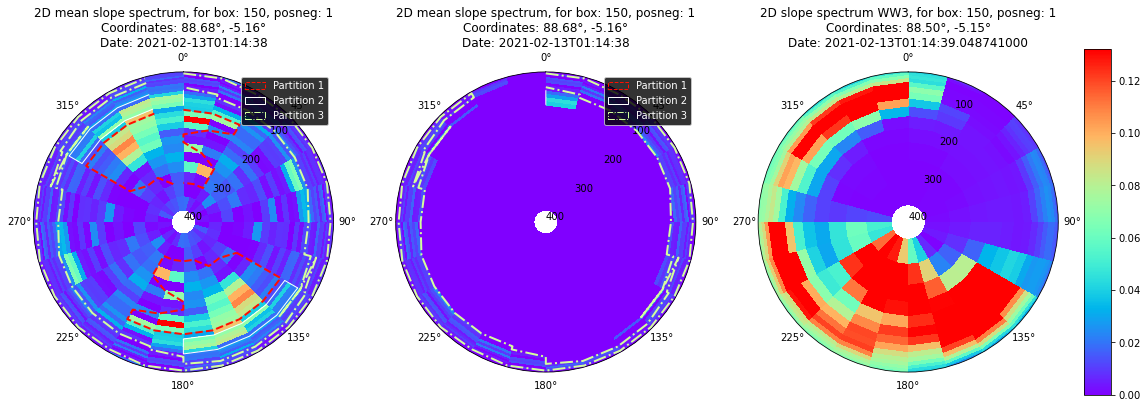

In [20]:
vmin, vmax = 0, ds_Raw_pro.data.max()
l_min, l_max = 30, 400

partitions = True
cmap = 'rainbow'

# partitions-spectra map
fig = plt.figure(figsize=(15,12), constrained_layout=True)
gs = fig.add_gridspec(1,3, wspace=0.2)
axt = fig.add_subplot(gs[0, 0], projection='polar')
axb = fig.add_subplot(gs[0, 1], projection='polar')
axc = fig.add_subplot(gs[0, 2], projection='polar')

# plot the SWIM 2D wave spectra for the selected box fig, gs, wave_spec, mask_comb, K_SPECTRA
fig, axt = plot_spectra.plotSpectra(fig, axt, ds_Raw_pro, mask_comb_or, K_SPECTRA, 
              num_box, nadir_side,
              N_PHI, l_min, l_max,
              vmin, vmax, True,
              lon_coor, lat_coor, date)

fig, axb = plot_spectra.plotSpectra(fig, axb, da_spectra_pro, mask_comb_pro, K_SPECTRA, 
                  num_box, nadir_side,
                  N_PHI, l_min, l_max,
                  vmin, vmax, partitions,
                  lon_coor, lat_coor, date)

title = '2D slope spectrum WW3, for box: ' + str(num_box) + ', posneg: '+ str(nadir_side)
suptitle = '\nCoordinates: {0:.2f}°, {1:.2f}°\nDate: {2}'.format(model_spec.lon.values, model_spec.lat.values, model_spec.time.values)
title += suptitle
    
fig, axc = plot_spectra.plotModel(fig, axc, model_spec, cmap, title, vmin, vmax, l_min, l_max)


## Distance propagation along geodesics

## Select sector and compute mean parameters

In [25]:
distance, bearing, bearing_p1 = spectra.geoBearing(lon_coor, lat_coor)

# Select sector and compute mean parameters
ds_spectra = ds_oneSide.sum(dim='part')
ds_sector = ds_spectra.isel(theta=np.argmin(np.abs(ds_spectra.theta.values - bearing)))
Hs,T,C,Ttime = spectra.meanParameters(ds_sector, distance, K_SPECTRA)


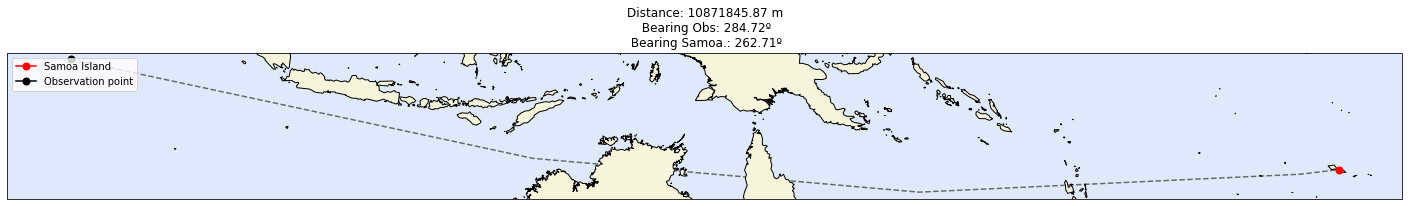

In [26]:
# example point
figsize=(25,15)
fig, ax = plot_sat.map_init(figsize)
ax = plot_sat.map_settings(ax)

#ax.set_extent([lon1_P-5, lon2_P+5, lat1_P-5, lat2_P+5])
ax.plot(site_lon, site_lat, markersize=7, marker='o', color='red', transform=ccrs.PlateCarree(), zorder=3, label=site)
ax.plot(lon_coor, lat_coor, markersize=7, marker='o', color='k', transform=ccrs.PlateCarree(), zorder=2, label='Observation point')
ax.plot([lon_coor, site_lon], [lat_coor, site_lat], '--', c='dimgray', transform=ccrs.Geodetic(), zorder=1)
plt.legend(loc='upper left')
ax.set_title('Distance: {0:.2f} m\n Bearing Obs: {1:.2f}º\n Bearing Samoa.: {2:.2f}º'.format(distance, bearing, bearing_p1))

plt.show()

In [27]:
# Plot masked spectra
Hs,T,C,Ttime = spectra.meanParameters(ds_sector, distance, K_SPECTRA)
print('Hs: {0}\nT: {1}\nC: {2}\nTravel time: {3}'.format(Hs, T, C, Ttime))

Hs: 0.20457654911278428
T: 6.922298710900262
C: 10.80344727084902
Travel time: 23 days, 7:04:22.365881


In [28]:
sector = np.argmin(np.abs(ds_spectra.theta.values - bearing))
ds_mask = ds_spectra.where(ds_spectra.theta==ds_spectra.theta.values[sector])

In [35]:
ds_spectra.theta.values[19]

285

In [29]:
# partitions-spectra map
fig = plt.figure(figsize=(7,7), constrained_layout=True)

fig = plot_spectra.plotSpectra(fig, ds_mask.slopeD, mask_comb, K_SPECTRA, 
                  num_box, nadir_side,
                  N_PHI, k_min, k_max,
                  vmin, vmax, partitions,
                  lon_coor, lat_coor, date)


TypeError: plotSpectra() missing 1 required positional argument: 'date'

<Figure size 504x504 with 0 Axes>